In [19]:
import os
import numpy as np

home = os.path.expanduser("~")

kitti = os.path.join(home, "buni", "dataset", "kitti-data","sequences")
scene_id = "00"
frame_id = "000200"
frame_path = os.path.join(kitti, scene_id, "velodyne",f"{frame_id}.bin")

points = np.fromfile(frame_path, dtype=np.float32).reshape(-1, 4)


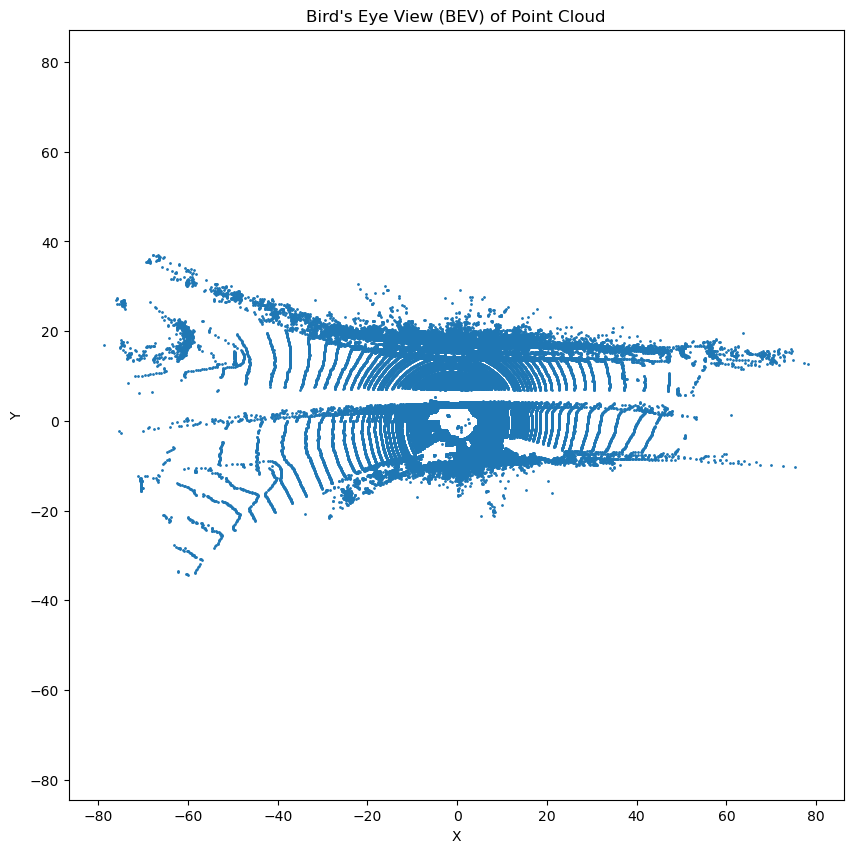

In [20]:
import matplotlib.pyplot as plt
def viz_points(points: np.ndarray):
    # Assuming points is an nx3 numpy array
    x = points[:, 0]
    y = points[:, 1]

    plt.figure(figsize=(10, 10))
    plt.scatter(x, y, s=1)  # s is the marker size
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Bird\'s Eye View (BEV) of Point Cloud')
    plt.axis('equal')
    plt.show()
    
viz_points(points[:,:3])

In [21]:
import open3d as o3d
def viz_pd(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # add coordinat axes to the point cloud
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])
    o3d.visualization.draw_geometries([pcd, mesh_frame])

viz_pd(points[:,:3])

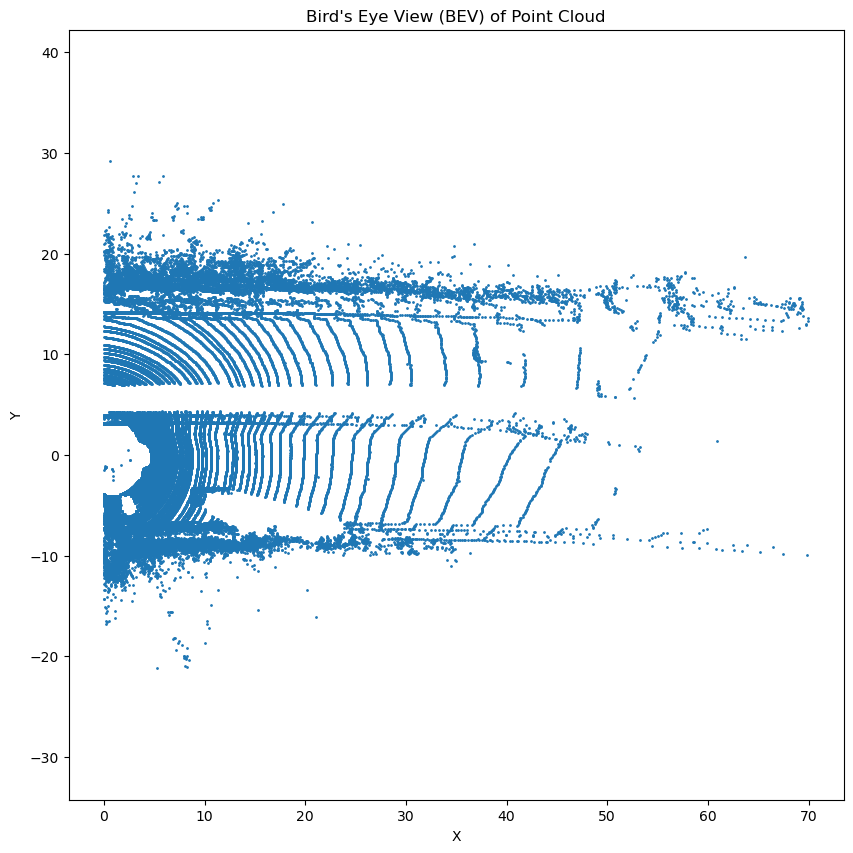

In [22]:
from typing import Tuple
import numpy as np
def filter_points_in_ROI(points: np.ndarray,x_range: Tuple[int, int], y_range: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Filter out points and corresponding beam IDs that are not in the region of interest (ROI).
    
    Parameters:
        points: np.ndarray
        beam_ids: np.ndarray
        x_range: Tuple[int, int]  # Range of x values (longitudinal axis)
        y_range: Tuple[int, int]  # Range of y values (lateral axis)
        
    Returns:
        Tuple of filtered points and corresponding beam IDs in the region of interest.
    """
    # Define the ROI boundaries
    x_min, x_max = x_range[0], x_range[1]   # Longitudinal (x-axis)
    y_min, y_max = y_range[0], y_range[1]   # Lateral (y-axis)

    # Apply the conditions to filter the points within the ROI
    in_roi = (points[:, 0] >= x_min) & (points[:, 0] <= x_max) & \
            (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
        
    # Use the conditions to index the original points and beam IDs arrays
    filtered_points = points[in_roi]

    return filtered_points

x_range=[0,70]
y_range=[-40,40]

points_roi = filter_points_in_ROI(points[:,:3], x_range, y_range)
viz_points(points_roi)

In [26]:
viz_pd(points_roi)

In [5]:
import ctypes
import time
import torch
from model import PIXOR
from postprocess import filter_pred, non_max_suppression
from utils import get_bev, plot_bev
class Detector(object):

    def __init__(self, config, cdll: bool):
        self.config = config
        self.cdll = cdll
        if self.cdll:
            self.LidarLib = ctypes.cdll.LoadLibrary('preprocess/LidarPreprocess.so')
        #self.device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
        self.device = torch.device('cpu')
        self.net = PIXOR(config['geometry'], config['use_bn']).to(self.device)

        self.net.set_decode(True)
        self.net.load_state_dict(torch.load(config['ckpt_name'], map_location=self.device))
        self.net.eval()

        for p in self.net.parameters():
            p.require_grad = False

        print("PIXOR BEV Detector Initialized!")

    def preprocess(self, velo: np.ndarray):
        """
        If cdll is True, use C++ library to preprocess all point clouds in the given path argument
        Otherwise, preprocess the point cloud `velo` in python
        
        Args:
            velo: numpy array representing a point cloud
            path: a string containing the path to the binary file of the point cloud
        
        return:
            torch.Tensor of shape (36, 800, 700) 
        """
        geom = self.config['geometry']
        def passthrough(velo):
            q = (geom['W1'] < velo[:, 0]) * (velo[:, 0] < geom['W2']) * \
                (geom['L1'] < velo[:, 1]) * (velo[:, 1] < geom['L2']) * \
                (geom['H1'] < velo[:, 2]) * (velo[:, 2] < geom['H2'])
            indices = np.where(q)[0]
            return velo[indices, :]

        velo = passthrough(velo)
        velo_processed = np.zeros(geom['input_shape'], dtype=np.float32)
        intensity_map_count = np.zeros((velo_processed.shape[0], velo_processed.shape[1]))
        for i in range(velo.shape[0]):
            x = int((velo[i, 1] - geom['L1']) / 0.1)
            y = int((velo[i, 0] - geom['W1']) / 0.1)
            z = int((velo[i, 2] - geom['H1']) / 0.1)
            velo_processed[x, y, z] = 1
            velo_processed[x, y, -1] += velo[i, 3]
            intensity_map_count[x, y] += 1
        velo_processed[:, :, -1] = np.divide(velo_processed[:, :, -1], intensity_map_count, \
                                                where=intensity_map_count != 0)

        velo_processed = torch.from_numpy(velo_processed).permute(2, 0, 1).to(self.device)
        velo_processed.require_grad=False
        return velo_processed

    def postprocess(self, pred):
        cls_pred = pred[..., 0]
        activation = cls_pred > self.config['cls_threshold']
        num_boxes = int(activation.sum())

        if num_boxes == 0:
            print("No bounding box found")
            return [], []

        corners = torch.zeros((num_boxes, 8))
        for i in range(1, 9):
            corners[:, i - 1] = torch.masked_select(pred[i, ...], activation)
        corners = corners.view(-1, 4, 2).numpy()
        scores = torch.masked_select(cls_pred, activation).cpu().numpy()

        # NMS
        selected_ids = non_max_suppression(corners, scores, self.config['nms_iou_threshold'])
        corners = corners[selected_ids]
        scores = scores[selected_ids]

        return corners, scores

    def __call__(self, velo):
        """
        velo is single lidar frame in form of a numpy array
        path is a string containing the path to that binary file of lidar frame
        """
        t_start = time.time()
        bev = self.preprocess(velo)
        t_pre = time.time()
        with torch.no_grad():
            pred = self.net(bev.unsqueeze(0)).squeeze_(0)

        t_m = time.time()
        corners, scores = filter_pred(self.config, pred)
        input_np = bev.permute(1, 2, 0).cpu().numpy()

        t_post = time.time()
        pred_bev = get_bev(input_np, corners)

        t_s = [t_pre-t_start, t_m-t_pre, t_post-t_m]
        return t_s, corners, scores, pred_bev

In [6]:
config = {
      "ckpt_name": "experiments/default/34epoch",
      "use_bn": True,
      "cls_threshold": 0.5,
      "nms_iou_threshold": 0.1,
      "nms_top": 64,
      "geometry": {
        'L1': -40.0,
        'L2': 40.0,
        'W1': 0.0,
        'W2': 70.0,
        'H1': -2.5,
        'H2': 1.0,
        'grid_size': 0.1,
        'input_shape': [800, 700, 36],
        'label_shape': [200, 175, 7],
        },
    }

In [24]:
def run(points: np.ndarray):
    pixor = Detector(config, cdll=False)
    time, corners, scores, pred_bev = pixor(points)
    return time, corners, scores, pred_bev

_, corners,_, pred_bev = run(points)

C:\Users\Ravi\AppData\Local\Temp\ipykernel_21540\3227258346.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(config['ckpt_name'], map

PIXOR BEV Detector Initialized!


In [8]:
import matplotlib
print(matplotlib.get_backend())


agg


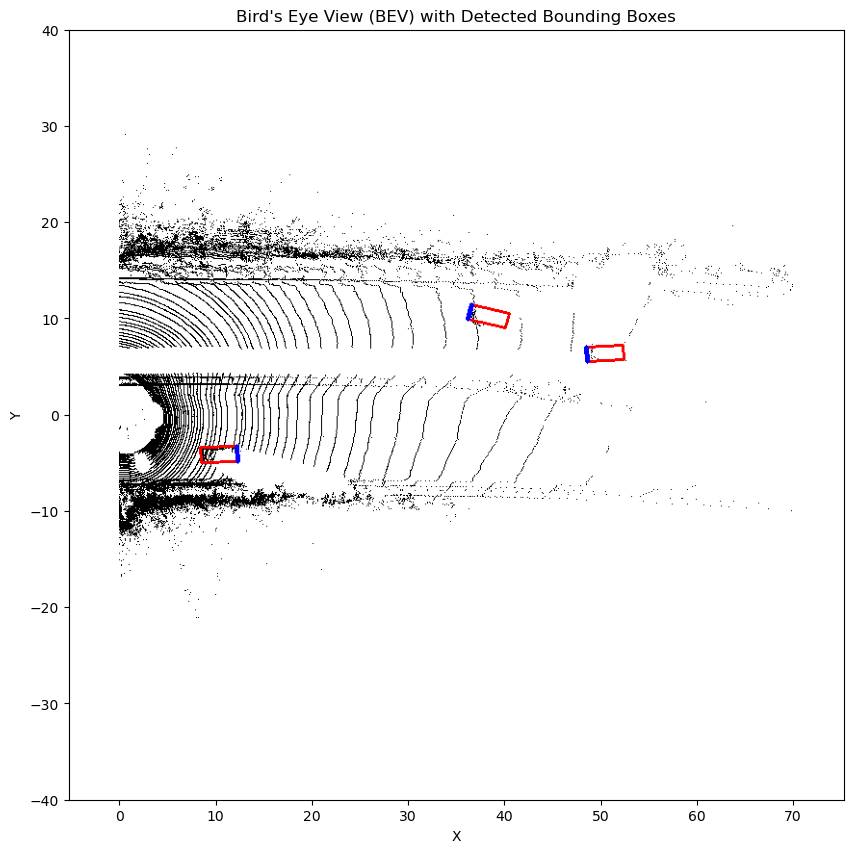

In [25]:
# corners has shape (n_boxes, 4, 2)
# Each box is represented by 4 corners, each corner has 2 coordinates (x, y)
# %matplotlib inline
# generate function to plot pred_bev on point cloud
# def plot_pred_bev_on_point_cloud(points: np.ndarray, corners: np.ndarray, pred_bev: np.ndarray):
#     # Assuming points is an nx3 numpy array
#     x = points[:, 0]
#     y = points[:, 1]

#     plt.figure(figsize=(10, 10))
#     plt.scatter(x, y, s=1)  # s is the marker size
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title('Bird\'s Eye View (BEV) of Point Cloud')
#     plt.axis('equal')
    
#     for box in corners:
#         box = np.vstack([box, box[0]])  # Close the box
#         plt.plot(box[:, 0], box[:, 1], color='red')
    
#     plt.imshow(pred_bev, alpha=0.5, extent=[0, 70, -40, 40], origin='lower')
#     plt.show()
    
# plot_pred_bev_on_point_cloud(points, corners, pred_bev)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def plot_pred_bev(pred_bev: np.ndarray):
    """
    Function to plot the Bird's Eye View (BEV) image with detected bounding boxes.
    
    Args:
    - pred_bev: numpy array representing the BEV image with detected bounding boxes overlaid.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(pred_bev, extent=[0, 70, -40, 40])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Bird\'s Eye View (BEV) with Detected Bounding Boxes')
    plt.axis('equal')
    plt.show()

# Example usage
plot_pred_bev(pred_bev)

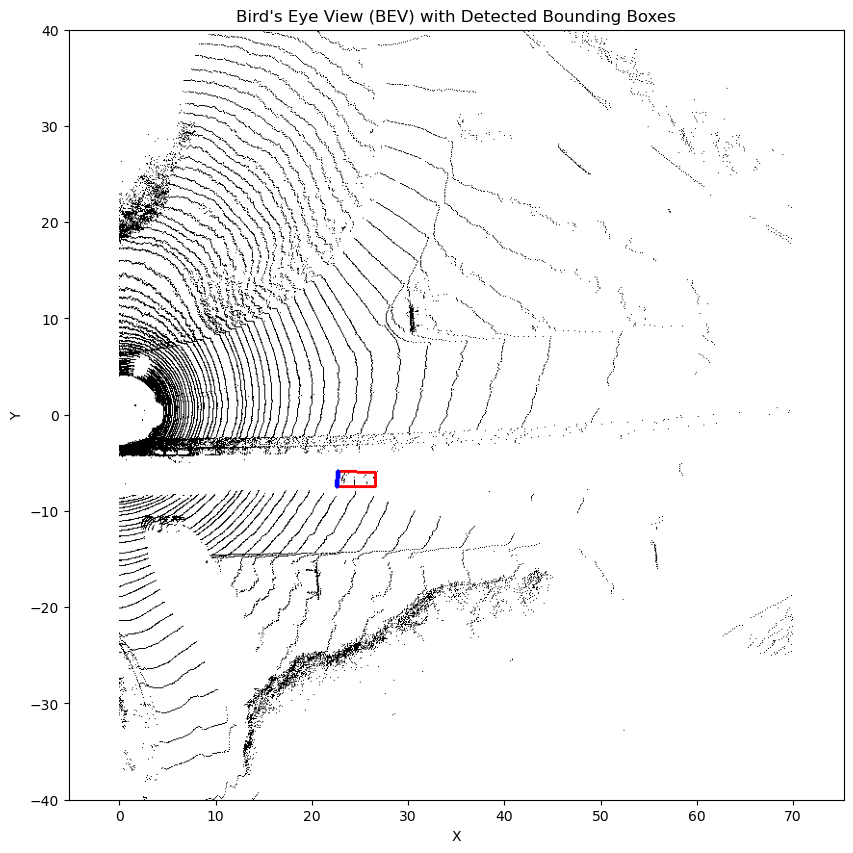

In [10]:
import matplotlib.pyplot as plt

# Assuming pred_bev is the BEV image provided by the Detector class
plt.figure(figsize=(10, 10))
plt.imshow(pred_bev, extent=[0, 70, -40, 40], origin='lower')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bird\'s Eye View (BEV) with Detected Bounding Boxes')
plt.axis('equal')
plt.show()